<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 6 : Autoencodeurs et détection de fraudes

## Résumé
Le but de ce laboratoire est d'entraîner des autoencodeurs sur des données de transactions bancaires, en mode non supervisé.  La fonction de coût sera la capacité de l'autoencodeur à reproduire en sortie les données d'entrée.  Trois réseaux de neurones autoencodeurs seront testés.

Ensuite, on considérera que les données mal reconstruites sont atypiques, et on testera l'hypothèse qu'il s'agit de transactions frauduleuses.  On utilisera donc cette information pour évaluer la capacité de l'autoencodeur à détecter les fraudes.

In [14]:
import numpy as np
import pandas as pd 
import keras # pour l'installation, "pip install tensorflow" suffira

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Données : source

Vous utiliserez un jeu de données fourni par le [Groupe ML de l'Université Libre de Bruxelles](http://mlg.ulb.ac.be/), disponible sur Kaggle : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.  Pour simplifier, une version vous est fournie sur Switchdrive dans un fichier [creditcard.zip](https://drive.switch.ch/index.php/s/lBqMRsADWrU2S4R).  Voici la description des données par les auteurs :

> The dataset contains transactions made by credit cards over two days in September 2013 by European cardholders.  It contains only numerical input variables which are the result of a PCA transformation (due to confidentiality issues).  Features V1, ..., V28 are the principal components.  Two features were not transformed: 'Time' (seconds since the 1st transaction) and 'Amount'.  

> The feature 'Class' takes value 1 in case of a fraudulent transaction and 0 otherwise.  There are 492 frauds out of 284,807 transactions (0.17%).  As the dataset is highly unbalanced, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC), not with confusion matrices.

## 1. Charger et préparer les données
a. Chargez les données de `creditcard.csv` directement dans une *dataframe* Pandas appelée `data`.

In [16]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


b. Affichez quelques informations sur ces données et leurs caractéristiques.

In [17]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

c. Construisez une nouvelle *dataframe* appelée `data_labels` contenant seulement l'attribut qui indique si une transaction est frauduleuse ou non (attribut `Class`).  Supprimez les attributs `Time` et `Class` de la *dataframe* initiale `data`.

In [18]:
data_labels = data['Class']
data.drop('Class', axis=1, inplace=True)
data.drop('Time', axis=1, inplace=True)

d. Normalisez toutes les colonnes de `data` vers des valeurs de moyenne nulle et d'écart-type égal à 1 (distribution centrée réduite). Utilisez pour cela le `StandardScaler` de scikit-learn.

In [19]:
scaler = StandardScaler()
data = scaler.fit_transform(data)



e. Pourquoi est-il acceptable ici de ne pas diviser `data` en données d'entraînement et de test ?

In [20]:
# Le dataset présente 0.17% de fraudes ce qui nous indique un dataset extrêmement déséquilibré.
# En outre, un split en deux ne serait pas très efficace si nous obtenons une répartition très homogène des classes


# 2. Définir les fonctions d'évaluation du modèle
Veuillez définir deux fonctions qui affichent :
   1. la courbe précision-rappel et la précision moyenne (qui est aussi la valeur de retour)
   1. la courbe ROC et l'aire sous la courbe (qui est aussi la valeur de retour)

Puis, veuillez recopier leur code et écrire une fonction qui affiche les deux courbes ensemble.

Ces fonctions, spécifiées ci-dessous, utilisent les classes et fonctions importées de `sklearn.metrics` au début de ce notebook.  Veuillez consulter leur documentation pour savoir comment les utiliser.

Une fonction auxiliaire vous est donnée, qui mesure l'erreur de reconstruction entre les données d'origine et celles reconstruites par un autoencodeur.

In [21]:
def reconstruction_error(X_orig, X_pred):
    '''
    Mesure l'erreur de reconstruction pour l'ensemble des données (compare 2 dataframes).
    Retourne une série avec l'erreur de chaque point de données.
    '''
    loss = np.sum((np.array(X_orig) - np.array(X_pred))**2, axis=1) # carré de l'erreur pour chaque item
    loss = pd.Series(data = loss, index = X_orig.index) # transformer en Series
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss)) # normalisation sur tous les items vers [0, 1]
    return loss


Veuillez écrire une fonction pour afficher la courbe précision-rappel et retourner la précision moyenne.  Veuillez écrire une fonction pour afficher la courbe ROC.  Enfin, veuillez copier le code dans une fonction qui affiche les deux courbes ensemble.  Les paramètres des fonctions sont les étiquettes correctes, les valeurs des erreurs de reconstruction, et en option les valeurs prédites par une méthode baseline, affichant ainsi deux courbes si elles sont fournies.  Leurs valeurs de retour sont respectivement la précision moyenne et l'aire sous la courbe ROC.

In [22]:
def display_pr_curve(labels, rec_errors, baseline=[]):
    display = PrecisionRecallDisplay.from_predictions(
        labels, rec_errors, name=f'Précision moyenne = {precision_moyenne:.2f}'
    )
    plt.title('Courbe Précision-Rappel')
    plt.grid(True)
    plt.show()
    
    return precision_moyenne


In [23]:
def display_roc_curve(labels, rec_errors, baseline=[]):
    auc = roc_auc_score(labels, rec_errors)
    display = RocCurveDisplay.from_predictions(
        labels, rec_errors, name=f'AUC = {auc:.2f}'
    )
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Aléatoire')
    plt.title('Courbe ROC')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return auc

In [24]:
def display_pr_roc(labels, rec_errors, baseline=[]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Courbe Précision-Rappel
    PrecisionRecallDisplay.from_predictions(
        labels, rec_errors, ax=ax1, name='Précision-Rappel'
    )
    ax1.set_title('Courbe Précision Rappel')
    ax1.grid(True)
    
    # Courbe ROC
    RocCurveDisplay.from_predictions(
        labels, rec_errors, ax=ax2, name='ROC'
    )
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Aléatoire')
    ax2.set_title('Courbe ROC')
    ax2.grid(True)
    
    plt.show()


## 3. Tester des modèles *baseline*

On considère deux modèles *baseline* pour des valeurs de reconstruction:
   1. des scores aléatoires dans [0, 1] pour chaque item : `np.random.rand(data.shape[0])`
   1. la norme L2 du vecteur d'attributs de chaque transaction, normalisée par colonne entre 0 et 1, qui peut être obtenue simplement ainsi avec la fonction définie plus haut : `reconstruction_error(data, np.zeros(data.shape[0]))`
   
Veuillez afficher les courbes précision-rappel et ROC pour ces deux *baselines* en même temps, grâce à la fonction précédente.

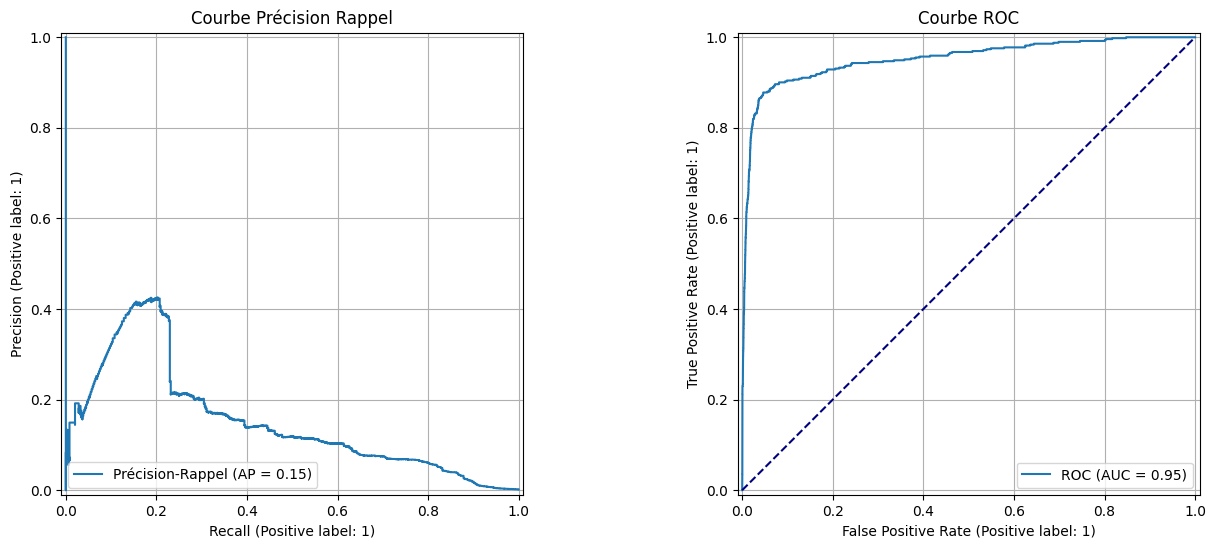

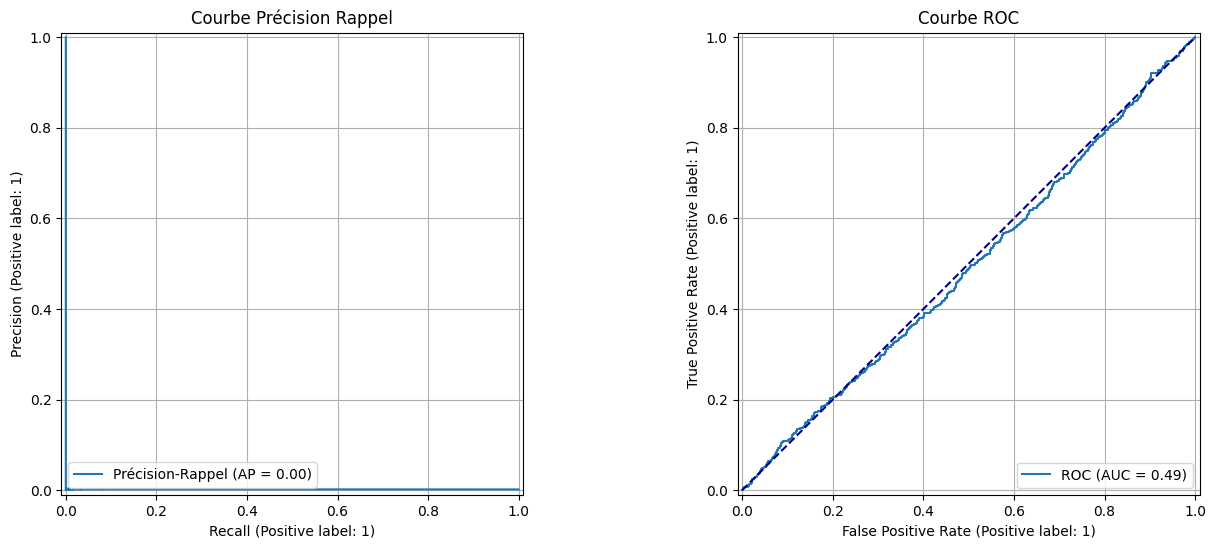

In [25]:
#Baseline 1 : Scores aléatoires dans [0, 1]
baseline_random_scores = np.random.rand(data.shape[0])

# Baseline 2 : Norme L2 comparée à un vecteur nul de même dimension
baseline_l2_scores = reconstruction_error(pd.DataFrame(data), np.zeros(data.shape))
# 
display_pr_roc(data_labels, baseline_l2_scores, baseline=baseline_random_scores)
# random vs null vector
display_pr_roc(data_labels, baseline_random_scores, baseline=baseline_l2_scores)


Sachant que les données proviennent d'une transformation PCA des données de transaction originales (auxquelles nous n'avons pas accès), pouvez-vous tenter d'expliquer le score non-nul obtenu par la 2e baseline ?

# vu que le dataset contient beaucoup de classes 02. Calcul de la norme L2 :
La norme L2 calcule la distance euclidienne entre chaque point de données et l'origine (dans ce cas un vecteur nul).

Cela revient à mesurer la "longueur" de chaque vecteur représentant une transaction.
Dans le cadre de données transformées par PCA, cette mesure capte une notion générale de complexité ou de dispersion des transactions.


Le score non-nul de la 2e baseline (norme L2) est expliqué par plusieurs facteurs :

Variance capturée : Même dans les données transformées par PCA, les transactions frauduleuses peuvent présenter une structure distincte en termes de variance.
Répartition asymétrique des anomalies : La fraude peut se traduire par des distances plus grandes par rapport à des transactions normales. La norme L2 capte donc cette séparation partielle.
Réduction de bruit : La PCA filtre une partie du bruit, laissant des signaux exploitables, que la norme L2 pourrait identifier.


Le score obtenu montre que même un modèle très simple, comme la norme L2, peut avoir un certain pouvoir prédictif sur des données transformées par PCA. 
Il ne s'agit pas d'un hasard, mais plutôt d'une preuve que la fraude modifie la distribution des attributs des transactions, ce que la norme L2 peut détecter partiellement.
Cependant, le score reste faible, indiquant que des modèles plus sophistiqués sont nécessaires pour une meilleure détection.

## 4. Définir des fonctions pour entraîner, valider, et évaluer des modèles

Veuillez définir une fonction `train` qui entraîne un *modèle* (que vous créerez plus bas avec Keras) sur un jeu de *données*, avec l'objectif de reconstruire les données (donc les données d'entrée et de sortie pour un entraînement supervisé sont identiques).  Toutes les *x* époques d'entraînement (`epochs_per_iteration`) la fonction `train` affiche les scores de *précision moyenne* et de *aire sous la courbe ROC*, mais pas les graphiques.  La fonction itère cela *y* fois (`nb_iterations`).

Veuillez définir aussi une fonction `evaluate` qui affiche les courbes précision-rappel et ROC pour un modèle, et inclut dans chaque graphique la *baseline* de la norme L2 des données initiales (2e baseline de la section 3).

Vous pouvez utiliser ces [méthodes de Keras](https://keras.io/api/models/model_training_apis) :
   * [model.fit(...)](https://keras.io/api/models/model_training_apis/#fit-method) pour lancer un certain nombre de pas d'entraînement (*backward pass*)
   * [model.predict(...)](https://keras.io/api/models/model_training_apis/#predict-method) pour exécuter le modèle sur des données et obtenir la sortie (*forward pass*)

In [44]:
def train(model, data, epochs_per_iteration = 3, nb_iterations = 5):

    for iteration in range(nb_iterations):
        print(f"Iteration {iteration + 1}/{nb_iterations}")
        
        model.fit(data, data, epochs=epochs_per_iteration, batch_size=32, verbose=1)
        reconstructed_data = model.predict(data)
        
        rec_errors = reconstruction_error(pd.DataFrame(data), reconstructed_data)
        ap_score = average_precision_score(data_labels, rec_errors)
        auc_score = roc_auc_score(data_labels, rec_errors)
        
        print(f"Précision Moyenne (AP) : {ap_score:.4f}")
        print(f"Aire Sous la Courbe ROC (AUC) : {auc_score:.4f}")
        print("\n")

In [37]:
def evaluate(model, data, data_labels):
    reconstructed_data = model.predict(data)
    
    rec_errors = reconstruction_error(pd.DataFrame(data), reconstructed_data)
    
    baseline_l2_scores = reconstruction_error(pd.DataFrame(data), np.zeros(data.shape))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    PrecisionRecallDisplay.from_predictions(
        data_labels, rec_errors, ax=ax1, name='Modèle (Précision-Rappel)'
    )
    PrecisionRecallDisplay.from_predictions(
        data_labels, baseline_l2_scores, ax=ax1, name='Baseline L2', color='orange', linestyle='--'
    )
    ax1.set_title('Courbe Précision-Rappel')
    ax1.grid(True)

    RocCurveDisplay.from_predictions(
        data_labels, rec_errors, ax=ax2, name='Modèle (ROC)'
    )
    RocCurveDisplay.from_predictions(
        data_labels, baseline_l2_scores, ax=ax2, name='Baseline L2', color='orange', linestyle='--'
    )
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Aléatoire')
    ax2.set_title('Courbe ROC')
    ax2.grid(True)
    
    # Afficher les courbes
    plt.show()

## 5. Créer, entraîner et évaluer des autoencodeurs 

### 5.1. Autoencodeur simple à trois couches

Veuillez définir en Keras un autoencodeur à trois couches, avec une couche de codage ayant une dimension plus faible que celle d'entrée (*undercomplete autoencoder*).  Utiliser un modèle de type `Sequential()` avec des couches entièrement connectées de type `Dense()`, en vous guidant sur les [exemples de Keras](https://keras.io/api/models/sequential/).  Choisissez une fonction de coût (*loss*) et un optimiseur appropriés.  N'oubliez pas de [compiler le modèle](https://keras.io/api/models/model_training_apis/#compile-method) à la fin.

In [53]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

def create_autoencoder(input_dim):
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    decoded = Dense(29, activation='relu')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder

model = create_autoencoder(data.shape[1])
model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 29)             │           493 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 973 (3.80 KB)

 Trainable params: 973 (3.80 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
#model.save('modele_1.h5')  # enregistrer le modèle
#del model  # supprimer le modèle de la mémoire
#model = keras.models.load_model('modele_1.h5') # charger le modèle

Veuillez entraîner le modèle avec la fonction `train` que vous avez définie plus haut.  Selon vos résultats intermédiaires, écrivez ici la commande qui semble suffisante pour atteindre le maximum de performance, et affichez ses résultats.  Notez que le modèle est sauvegardé, donc plusieurs appels à `train` permettent de continuer l'entraînement.  Dans votre rapport final, indiquez explicitement la durée totale en nombre d'époques.

In [54]:
train(model, data)

Iteration 1/5
Epoch 1/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.7657
Epoch 2/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6447
Epoch 3/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6300
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Précision Moyenne (AP) : 0.2015
Aire Sous la Courbe ROC (AUC) : 0.9516


Iteration 2/5
Epoch 1/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.6323
Epoch 2/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.6239
Epoch 3/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.6315
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Précision Moyenne (AP) : 0.2018
Aire Sous la Courbe ROC (AUC) : 0.9517


Iteration 3/5
Epoch 1/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6343
Epoch 2/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6194
Epoch 3/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6231
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Précision Moyenne (AP) : 0.1993
Aire Sous la Courbe ROC (AU

Veuillez afficher les deux courbes (y compris les *baselines*), et les scores du modèle avec la fonction `evaluate`.

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 952us/step


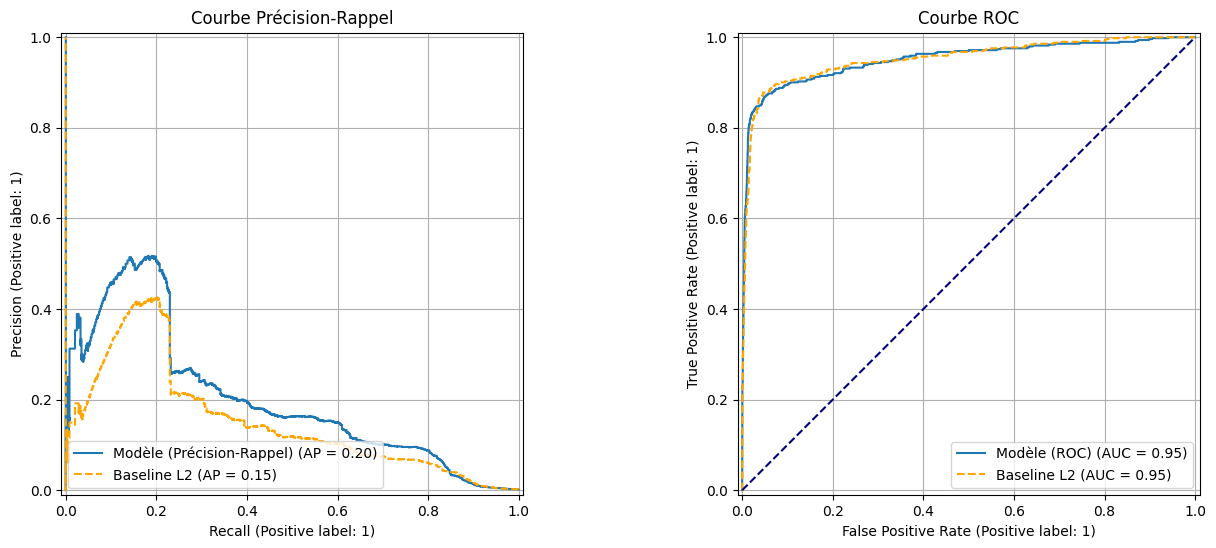

In [55]:
evaluate(model, data, data_labels)

**Veuillez discuter vos résultats.**  Comment jugez-vous la capacité du modèle à détecter des transactions frauduleuses, compte tenu du fait qu'il n'a jamais été entraîné de manière supervisée ?  Comment se compare-t-il avec la baseline ?  Quelle est sa précision maximale, et pour quel rappel est-elle atteinte ?  (Approximativement, d'après le graphique.)  Comment interprétez-vous ces valeurs ?

### 5.2. Autoencodeur à cinq couches

Veuillez définir maintenant un autoencodeur à cinq couches, sur le même principe que le précédent, toujours *undercomplete*.  Effectuez son entraînement et son évaluation finale, comme pour le modèle à 3 couches.

In [62]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

def create_autoencoder(input_dim):
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    x = Dense(8, activation='relu')(encoded)
    x = Dense(16, activation='relu')(x)
    decoded = Dense(29, activation='relu')(x)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder

model = create_autoencoder(data.shape[1])
model.summary()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 29)             │           493 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253 (4.89 KB)

 Trainable params: 1,253 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train(model, data)

Iteration 1/5
Epoch 1/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.8418
Epoch 2/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.7175
Epoch 3/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.7005
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Précision Moyenne (AP) : 0.2122
Aire Sous la Courbe ROC (AUC) : 0.9507


Iteration 2/5
Epoch 1/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.6942
Epoch 2/3
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.6983
Epoch 3/3
6461/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6916

In [ ]:
model.save('modele_2.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

In [ ]:
evaluate(model, data, data_labels)

Veuillez discuter vos résultats et les comparer avec les précédents.

### 5.3. Autoencodeur à trois couches, *overcomplete*, avec *sparsity*
Veuillez enfin définir un autoencodeur à trois couches, mais avec une couche cachée ayant une dimension supérieure à celle des couches d'entrée et de sortie.  Afin d'éviter la pure copie entrée/sortie, ajoutez une contrainte de régularisation sur la couche cachée, qui limite la somme des valeurs absolues des activations dans cette couche (voir la [documentation](https://keras.io/api/layers/regularizers/) de Keras).

In [ ]:
train(model, data, 10, 10)

In [ ]:
# model.save('modele_3.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

In [ ]:
evaluate(model, data, data_labels)

Veuillez discuter vos résultats et les comparer avec les précédents.

### Fin du laboratoire 6
Veuillez nettoyer le *notebook* et y inclure l'affichage des résultats de vos systèmes définitifs.  Ne pas effacer les logs d'entraînement et les graphiques.  Veuillez ensuite soumettre le *notebook* sur Cyberlearn.